In [7]:
import main
import os

In [ ]:
img_path = "/data/geometric shapes dataset/Circle/Circle_0a0b51ca-2a86-11ea-8123-8363a7ec19e6.png"

# cv2.imread does not work on linux, im using matlab for visualization
img = main.load_img(img_path)
print(img)
main.plt.imshow(img)

folder_path = os.path.join(os.getcwd(), 'data', 'geometric shapes dataset', 'Square')
data = main.load_img_from_folder(folder_path)
print(len(data))


[ WARN:0@113.044] global loadsave.cpp:275 findDecoder imread_('/home/szh/Documents/umich/eecs442/final project/data/geometric shapes dataset/Circle/Circle_0a0b51ca-2a86-11ea-8123-8363a7ec19e6.png'): can't open/read file: check file path/integrity


FileNotFoundError: File not found at: /home/szh/Documents/umich/eecs442/final project/data/geometric shapes dataset/Circle/Circle_0a0b51ca-2a86-11ea-8123-8363a7ec19e6.png

(200, 200)
[]


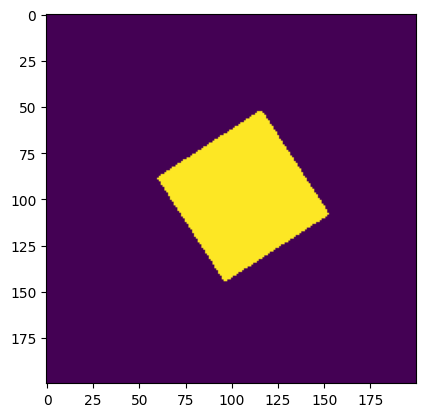

In [ ]:
img = data[0]
print(img.shape)
main.plt.imshow(img)
lines = main.detect_line(img, canny_thres1=10, 
             canny_thres2=150, 
             rho=1, 
             theta=main.np.pi/180, 
             hough_thres=80, 
             min_line_len=30, 
             max_line_gap=10)
print(lines)

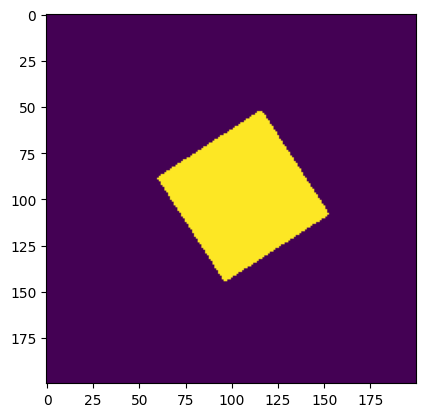

In [9]:
out = main.draw_lines(img, lines)
main.plt.imshow(out)